<a href="https://colab.research.google.com/github/Freddyyusuf/semantic-segmentation-effnet-fpn/blob/master/exp_01_camvid_B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 12.2 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB4 as EfficientNet
import numpy as np
from tensorflow_addons import layers as tfa_layers
from tensorflow_addons import losses as tfa_losses
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import seaborn as sns

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# download the dataset (zipped file)
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU -O /tmp/fcnn-dataset.zip 

# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /tmp/fcnn-dataset.zip
100% 126M/126M [00:01<00:00, 82.8MB/s]


In [ ]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

In [ ]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=384, width=384):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image
  # image -= 1

  return image, annotation

In [ ]:
!ls /tmp/fcnn/dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [ ]:
# Utilities for preparing the datasets

BATCH_SIZE = 16

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset


In [ ]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [ ]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [ ]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  # image = image + 1
  image = image #* 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  # image = image + 1
  image = image #* 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

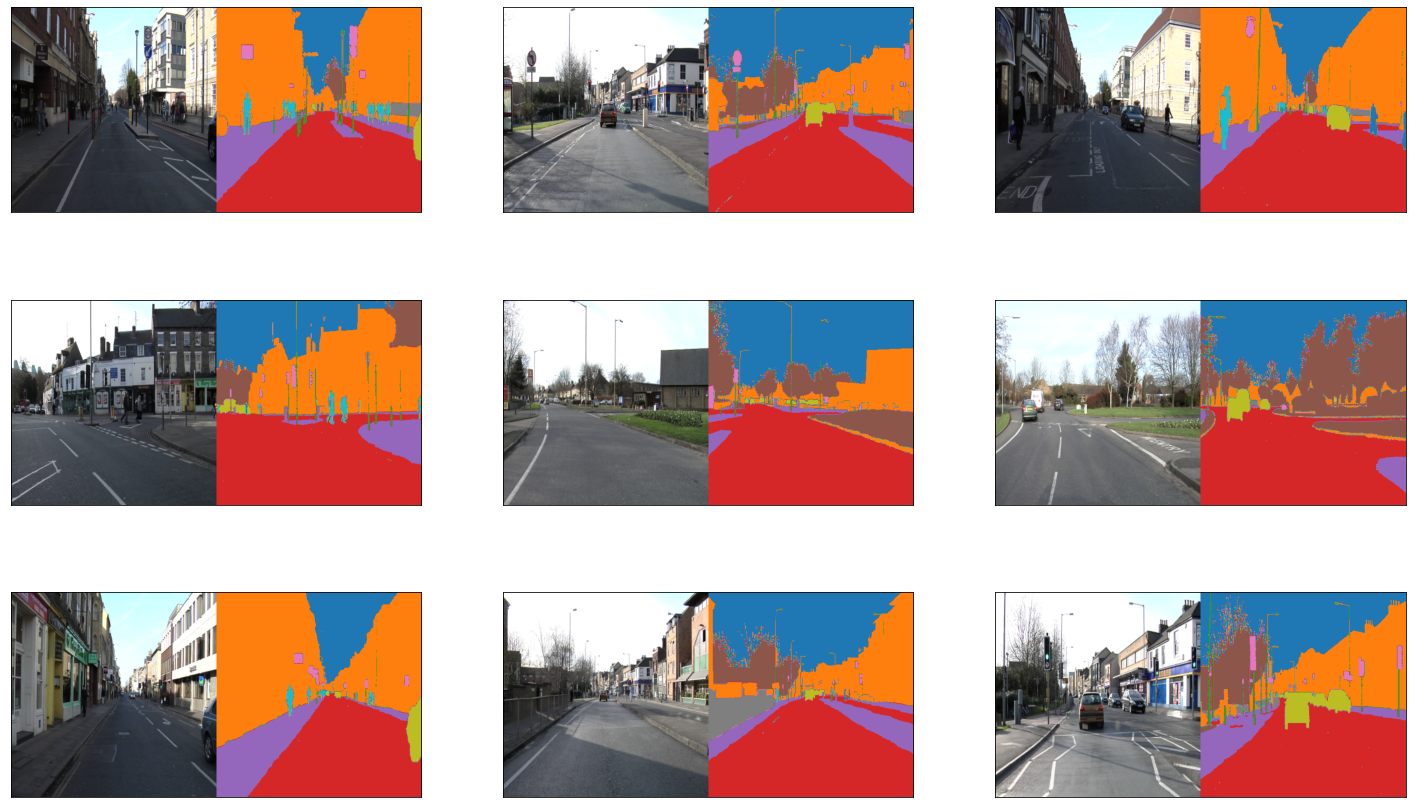

In [ ]:
list_show_annotation(training_dataset)

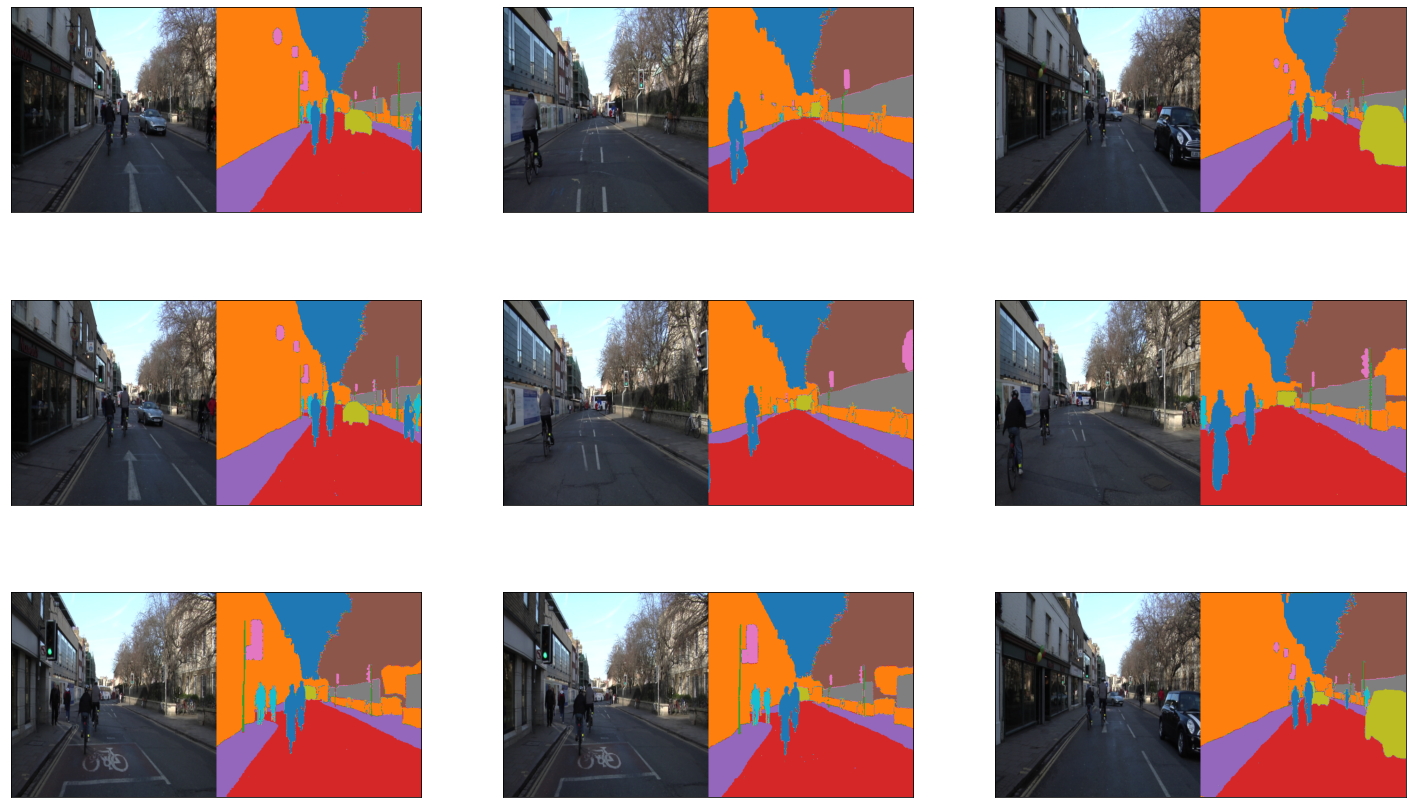

In [ ]:
list_show_annotation(validation_dataset)

In [ ]:
EFFICIENTNET_LEVEL_ENDPOINTS = [
    'block1b_add',
    'block2d_add',
    'block3d_add',
    'block5f_add',
    'block7b_add',
] # For B4


backbone = EfficientNet(include_top=False, weights='imagenet', input_shape=(384, 384, 3))
backbone.trainable = False
output_layers = [backbone.get_layer(layer_name).output
                 for layer_name in EFFICIENTNET_LEVEL_ENDPOINTS]

base_model = Model(inputs=backbone.input, outputs=output_layers)



71696384/71686520 [==============================] - 2s 0us/step


In [ ]:
def conv_block_up(input, iteration, kernel_size=(3,3), strides_size=(1,1), upsample=True):
    b = input
    for i in range(iteration):
        b = layers.Conv2D(128, kernel_size=kernel_size, strides=strides_size, padding='same')(b)
        b = tfa_layers.GroupNormalization(groups=8)(b)
        # b = layers.BatchNormalization()(b)
        b = layers.Activation('relu')(b)
        if upsample:
            b = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(b)
        
    return b

output_5 = conv_block_up(base_model.output[4], 4)
output_4 = conv_block_up(base_model.output[3], 3)
output_3 = conv_block_up(base_model.output[2], 2)
output_2 = conv_block_up(base_model.output[1], 1)
output_1 = conv_block_up(base_model.output[0], 1, upsample=False)

x = layers.Add()([output_5, output_4])
x = layers.Add()([x, output_3])
x = layers.Add()([x, output_2])
x = layers.Add()([x, output_1])

x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(12, kernel_size=(2,2), strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax')(x)
print(x.shape)

(None, 384, 384, 12)


In [ ]:
final_model = Model(inputs=base_model.input, outputs=x)
final_model.summary()

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
                    loss= tfa_losses.SigmoidFocalCrossEntropy(reduction=tf.keras
                                                              .losses.Reduction
                                                              .AUTO),
                    metrics=['accuracy'])
final_model.load_weights("/content/camvid_ckpt/ckptv01")

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.1,
                                                patience=4,
                                                min_delta=0.001)

In [ ]:
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 100

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = final_model.fit(training_dataset,
                          steps_per_epoch=steps_per_epoch, 
                          validation_data=validation_dataset, 
                          validation_steps=validation_steps, 
                          epochs=EPOCHS,
                          callbacks=[early_stop, lr_decay])

Epoch 1/100
22/22 [==============================] - 90s 2s/step - loss: 0.2227 - accuracy: 0.7166 - val_loss: 2.6540 - val_accuracy: 0.3258 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 43s 2s/step - loss: 0.1378 - accuracy: 0.8086 - val_loss: 0.9068 - val_accuracy: 0.5515 - lr: 0.0100
Epoch 3/100
22/22 [==============================] - 42s 2s/step - loss: 0.1177 - accuracy: 0.8385 - val_loss: 0.3338 - val_accuracy: 0.7128 - lr: 0.0100
Epoch 4/100
22/22 [==============================] - 42s 2s/step - loss: 0.1085 - accuracy: 0.8475 - val_loss: 0.1729 - val_accuracy: 0.7864 - lr: 0.0100
Epoch 5/100
22/22 [==============================] - 42s 2s/step - loss: 0.1017 - accuracy: 0.8562 - val_loss: 0.1514 - val_accuracy: 0.7935 - lr: 0.0100
Epoch 6/100
22/22 [==============================] - 42s 2s/step - loss: 0.0940 - accuracy: 0.8663 - val_loss: 0.1029 - val_accuracy: 0.8256 - lr: 0.0100
Epoch 7/100
22/22 [==============================] - 42s 2s/step - loss: 0.0

In [ ]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [ ]:
# get the model prediction
import time
start=time.time()
results = final_model.predict(validation_dataset, steps=validation_steps)
print(f'for 101 val example, total time = {time.time()-start}s')
# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

for 101 val example, total time = 5.425413131713867s


In [ ]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

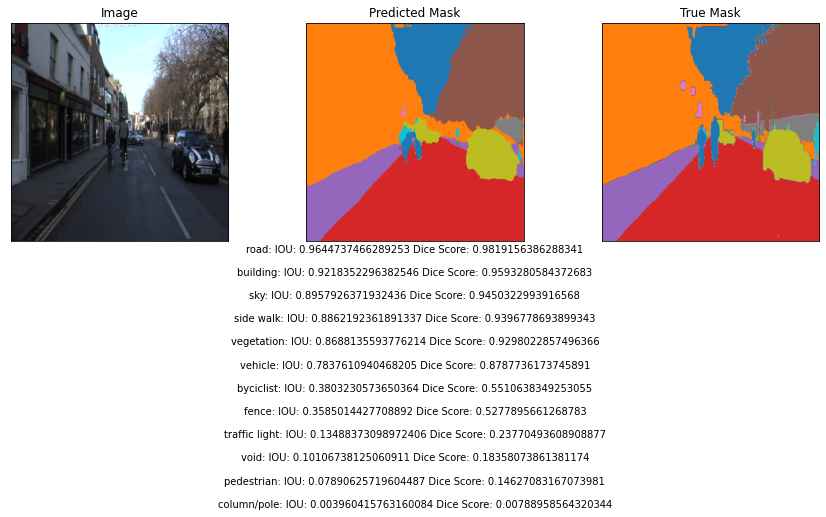

In [ ]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 43

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

In [ ]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)


ValueError: ignored

In [ ]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 


In [ ]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


In [ ]:
final_model.save_weights('/content/drive/MyDrive/camvid_ckpt/ckptv01')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
